# Detección de URL Maliciosas mediante modelos Machine Learning

<h2 style="width: 100%;
    margin: 0;
    padding: 0;
    text-align: center;">---- Table of contents ----</h2>

1. [Importing Libraries](#1)
2. [Load Dataset](#2)
3. [Meta information of Dataframe](#3)
4. [Checking for NaN values](#4)
5. [Feature Extraction](#5)
6. [Train & Test Split](#6)
7. [Training models](#7)
  <ul>
      <li>✔️ Decision Tree Classifier</li>
      <li>✔️ Random Forest Classifier</li>
      <li>✔️ AdaBoost Classifier</li>
      <li>✔️ KNeighbors Classifier</li>
      <li>✔️ SGD Classifier</li>
      <li>✔️ Extra Trees Classifier</li>
      <li>✔️ Gaussian NB</li>
  </ul>
8. [Final Report](#8)


## Gestor de paquetes python.

La librería tld (Top Level Domain extractor) permite extraer y validar el dominio de una URL. Es muy útil en ciberseguridad porque muchos ataques se esconden en TLDs poco comunes o sospechosos (.xyz, .tk, .top, etc.).

In [ ]:
pip install tld

Note: you may need to restart the kernel to use updated packages.


<a id="1"></a> <br>
# 📥 Importando Librerias

## Librerías de manejo de datos y utilidades

`import re`
→ Permite trabajar con expresiones regulares, muy útiles para extraer patrones de texto (ej: detectar si una URL tiene números, subdominios raros, etc.).

`import numpy as np`
→ Biblioteca para trabajar con arrays numéricos y operaciones matemáticas rápidas.

`import pandas as pd`
→ Manejo de datasets tabulares (archivos .csv, .xlsx, etc.). Ideal para cargar, limpiar y explorar datos.

## Visualización de datos

`import seaborn as sns`
→ Librería para visualización estadística basada en matplotlib. Permite hacer gráficos como heatmaps, distribuciones, correlaciones, etc.

`import matplotlib.pyplot as plt`
→ Librería clásica de gráficos. Da control total para personalizar visualizaciones.

`from colorama import Fore`
→ Permite imprimir mensajes en la terminal con colores. Útil para resaltar resultados (por ejemplo, mostrar en verde si un modelo tuvo buena precisión).

## Procesamiento de URLs

`from urllib.parse import urlparse`
→ Sirve para descomponer una URL en partes (protocolo, dominio, path, query, etc.). Muy usado en datasets de ciberseguridad con URLs.

`from tld import get_tld, is_tld`
→ Permite extraer y validar el TLD (Top-Level Domain, como .com, .org, .xyz) de una URL.
Ejemplo: get_tld("http://phishing-site.xyz") devuelve "xyz".

## Machine Learning (scikit-learn)

`from sklearn.model_selection import train_test_split`
→ Sirve para dividir el dataset en train (entrenamiento) y test (evaluación).

`from sklearn.metrics import confusion_matrix, classification_report, accuracy_score`
→ Funciones para evaluar modelos:

    - Confusion Matrix: aciertos y errores por clase.
    
    - Classification Report: precisión, recall, F1-score.
    
    - Accuracy: porcentaje de aciertos global.

### Modelos de clasificación:
    
    1. DecisionTreeClassifier → Árbol de decisión. Modelo simple, interpretable.
    
    2. RandomForestClassifier → Ensamble de árboles, más robusto.
    
    3. AdaBoostClassifier → Ensamble que mejora iterativamente clasificadores débiles.
    
    4. ExtraTreesClassifier → Variante más aleatoria que Random Forest.
    
    5. KNeighborsClassifier → Clasificación basada en vecinos más cercanos.
    
    6. SGDClassifier → Clasificador rápido basado en descenso de gradiente estocástico.
    
    7. GaussianNB → Clasificador Naive Bayes gaussiano, muy usado en texto/URLs.

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

<a id="2"></a> <br>
# 🗃️ Cargar Dataset

`pd` → es el alias de a pandas.

`read_csv()` → función de pandas para leer un archivo CSV y convertir en un DataFrame.

`../input/malicious-urls-dataset/malicious_phish.csv` → es la ruta del archivo CSV que contiene el dataset:

`/input/malicious-urls-dataset/` → carpeta donde está almacenado el dataset en Kaggle.

`malicious_phish.csv` → archivo que contiene las URLs con su etiqueta (benigna, phishing, malware, etc.).

`data` → será el nombre del DataFrame que guarda todo el dataset.


Cargamos el dataset `malicious_phish.csv` al DataFrame de pandas.

`head()` → muestra las primeras 5 filas del DataFrame.

In [ ]:
data = pd.read_csv('../input/malicious-urls-dataset/malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


<a id="3"></a> <br>
# 📝 Procesamiento de los Datos

<a id="3"></a> <br>
# 📝 Meta information of Dataframe

### `info()` → es un método de pandas DataFrame, muestra un resumen completo del Dataset, que incluye:

    1. Número de filas y columnas → tamaño del dataset.
    
    2. Nombre de cada columna.
    
    3. Número de valores no nulos en cada columna (sirve para detectar datos faltantes).
    
    4. Tipo de dato de cada columna (object, int64, float64, etc.).
    
    5. Uso de memoria del DataFrame.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


# Limpieza, Transformado y Adaptado de los datos.

<a id="4"></a>
# 🔎 Checking for NaN values

### data.isnull() → Revisa todo el DataFrame y devuelve una tabla booleana del mismo tamaño:

    1. True si el valor es nulo (faltante).
    
    2. False si el valor está presente.

### .sum()

    1. Aplica una suma por columna: cuenta cuántos `True` existen (True=1 y False=0).

    2. Se obtiene el número total de valores nulos por columna.


**Verificamos si existen valores nulos en las columnas (`url y type`). Devuelve el valor existe en cada una.**

**El Dataset devuelve 0, es decir está limpio.**

In [ ]:
data.isnull().sum()

url     0
type    0
dtype: int64

**`data.type.value_counts()` → cuenta cuántos registros existen de las etiquetas `(benign, phishing, malware, defacement).`**

Almacena el valor en la variable `count.`

**`count` = Imprime el valor.**

In [ ]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

### Seaborn crea un gráfico de barras.

`x=count.index` → las etiquetas de las clases (benign, phishing, etc.).

`y=count` → el número de URLs de cada clase.

`plt.xlabel y plt.ylabel` = los títulos de los ejes.

## El gráfico indica el desbalance del dataset (Existen más URLs benignas que malware).

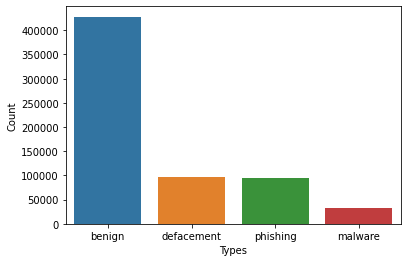

In [ ]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count');

<h4>first have to omit the (www.) from the URL which is in fact a sub domain in itself.</h4>

### Reemplazamos el texto "www." en las URLs por vacío "".

`regex=True` =  indica que la búsqueda se hace con expresiones regulares para normalizar las URLs, ya que "www.google.com" y "google.com" redirigen al mismo sitio.

In [ ]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


### Muestra nuevamente las primeras 5 filas para verificar que el reemplazo de "www." se aplicó correctamente.

In [ ]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


### Se crea un diccionario `rem` con un mapeo de categorías a números:

    1. benign → 0
    
    2. defacement → 1
    
    3. phishing → 2
    
    4. malware → 3

Se añade una nueva columna `Category` copiando el contenido de type.

### `data.replace(rem)` → reemplaza los valores de la columna Category según el diccionario.

In [ ]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

<a id="5"></a> <br>
# 🦾 Feature Extraction

## El bloque de `feature extraction` es la parte central del preprocesamiento, porque convierte cada URL en un conjunto de números que los algoritmos de Machine Learning sí entienden.

`data['url_len'] = data['url'].apply(lambda x: len(str(x)))`

    Crea una columna url_len con el número de caracteres de cada URL.

    URLs maliciosas suelen ser más largas o cortas (cuando usan acortadores).

In [ ]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

### Hacemos uso de la herramienta TLD
    
    1. Extraemos el dominio principal de la URL.
    
    2. Si falla, devuelve None.
    
    3. Esto sirve porque muchos dominios raros o recién creados son sospechosos.

In [ ]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [ ]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [ ]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


### Recorremos la lista de caracteres especiales y creamos una columna por cada uno.

    1. Calculamos cuántos @ tiene la URL.
    
    2. Estos símbolos son típicos en URLs falsas que intentan engañar al usuario.

In [ ]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [ ]:
data.head()

### Verificamos si ¿La URL es "anormal"?

    1. Comparamos el hostname real con lo que aparece en la URL.
    
    2. Si no coinciden, la URL se marca como anormal (0/1) → típico en phishing.

In [ ]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

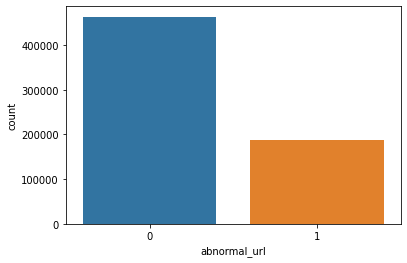

In [ ]:
sns.countplot(x='abnormal_url', data=data);

### Verificamos si el enlace ¿Usa HTTPS?

    1. 1 = usa HTTPS, 0 = No.
    
    2. Muchas webs falsas no usan HTTPS.

In [ ]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [ ]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

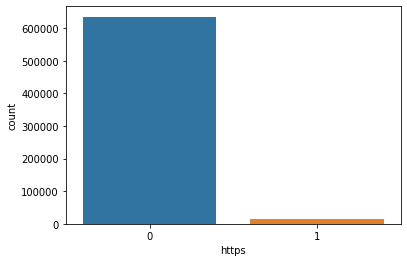

In [ ]:
sns.countplot(x='https', data=data);

<h4>Counts the number of digit characters in a URL</h4>

### Verificamos contando dígitos y letras
    
    1. Añade cuántos números (digits) y letras (letters) tiene la URL.
    
    2. Un exceso de números en el dominio suele ser sospechoso.

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [ ]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

<h4>Counts the number of letter characters in a URL</h4>

In [ ]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [ ]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

<h4>Checks to see whether URL contains a shortening service</h4>

### Verificamos si ¿La URL contiene una dirección IP?

    1. Verificamos si la URL viene de un servicio acortador.
    
    2. Muy usado por atacantes para ocultar el destino real.

### Definimos una Funcion acortadores de un repositorio conocido.

In [ ]:
def Shortining_Service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

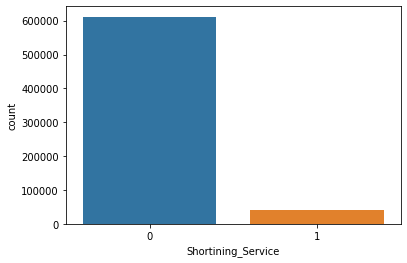

In [ ]:
##sns.countplot(x='Shortining_Service', data=data);

### Verificamos si ¿La URL contiene una dirección IP?

    1. Si el dominio es directamente una IP (ej: http://192.168.1.1/...), es muy sospechoso.
    
    2. Los sitios legítimos casi nunca usan IP en lugar de dominio.

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

In [ ]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
data['having_ip_address'].value_counts()

0    638703
1     12488
Name: having_ip_address, dtype: int64

# Matriz de Correlación

    1. Visualiza cómo se relacionan las variables entre sí.
    
    2. url_len se correlacionarse con la cantidad de símbolos especiales.

<AxesSubplot:>

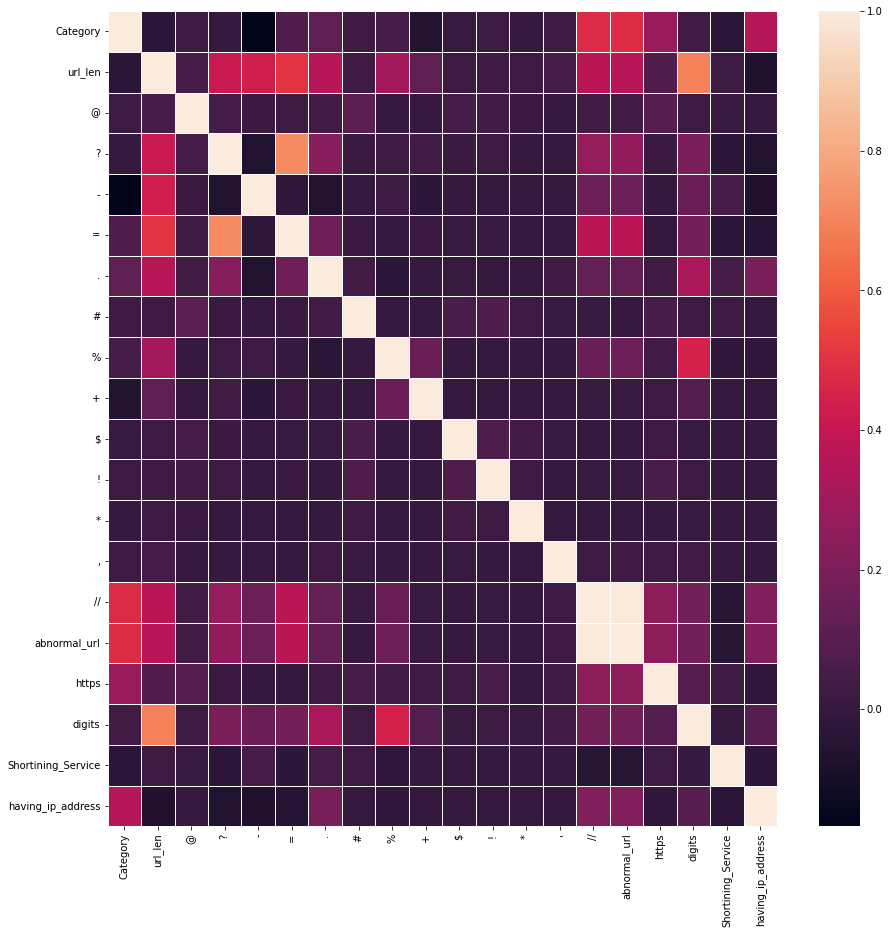

In [ ]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(), linewidths=.5)

# Preparar datos para los Modelos de Machine Learning

**1. X: todas las features numéricas extraídas.**
    
**2. y: la categoría (benign=0, defacement=1, phishing=2, malware=3).**

In [ ]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

<a id="6"></a> <br>
# ✂️ Train & Test Split

### Se separan los datos en 80% entrenamiento y 20% prueba.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## En todo el bloque se convierte URLs de texto en vectores de números que contienen patrones de seguridad (longitud, símbolos, HTTPS, IP, acortadores, etc.).

<a id="7"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/32/4149/4149680.png"/> Training models

### Importamos las funciones de la biblioteca scikit-learn, que se usa en machine learning con Python

Creamos la matriz de confusión con `plot_confusion_matrix` el cual corresponde a un modelo de clasificación, para visualizar los resultados de la matriz. 
La matriz de confusión indica cuántas predicciones fueron correctas y cuántas incorrectas, separadas por clase.
- Ejes: filas = clases reales, columnas = clases predichas.

La curva `ROC (Receiver Operating Characteristic)`, evalúa el rendimiento de un modelo de clasificación binaria.
- Ejes: Tasa de verdaderos positivos vs. tasa de falsos positivos.
- Área bajo la curva (AUC): cuanto más cerca de 1, mejor el modelo.
- Útil para: comparar modelos, especialmente cuando hay clases desbalanceadas.


In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

## Definimos una lista de modelos de Machine Learning para probar

### Los modelos son:
- Árbol de decisión (DecisionTreeClassifier)
- Bosque aleatorio (RandomForestClassifier)
- AdaBoost (AdaBoostClassifier)
- KNN (KNeighborsClassifier)
- SGD (Stochastic Gradient Descent)
- ExtraTreesClassifier (árboles extremadamente aleatorios)
- Naive Bayes Gaussiano (GaussianNB)

In [ ]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,KNeighborsClassifier,SGDClassifier,
         ExtraTreesClassifier,GaussianNB]

### Creamos una lista vacía para ir guardando la accuracy (exactitud) de cada modelo.

In [ ]:
accuracy_test=[]

### Inicializamos un bucle para recorrer cada modelo de la lista - m corresponde la clase del modelo en cada interracción.
- model_ = DecisionTreeClassifier() y sucesivamente con el resto de modelos.

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  90.93%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     85565
           1       0.93      0.96      0.94     19319
           2       0.80      0.57      0.66     18805
           3       0.94      0.91      0.93      6550

    accuracy                           0.91    130239
   macro avg       0.90      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

             Confusion_matrix 


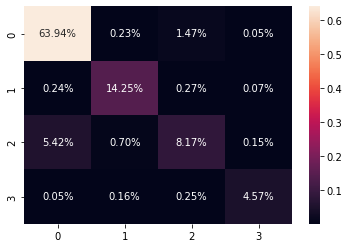

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  91.50%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.83      0.58      0.68     18805
           3       0.96      0.91      0.94      6550

    accuracy                           0.92    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.92      0.91    130239

             Confusion_matrix 


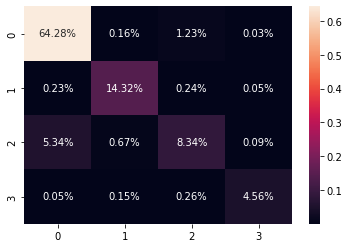

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  82.01%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.84      0.98      0.90     85565
           1       0.82      0.89      0.85     19319
           2       0.45      0.15      0.22     18805
           3       0.91      0.46      0.61      6550

    accuracy                           0.82    130239
   macro avg       0.75      0.62      0.65    130239
weighted avg       0.78      0.82      0.78    130239

             Confusion_matrix 


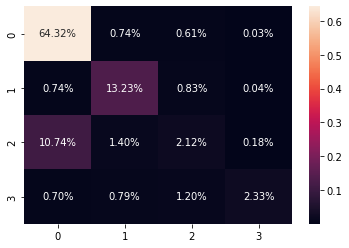

###################- End -###################
#############################################
######-Model => <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test Accuracy :  88.96%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     85565
           1       0.89      0.95      0.92     19319
           2       0.73      0.53      0.62     18805
           3       0.94      0.87      0.91      6550

    accuracy                           0.89    130239
   macro avg       0.87      0.83      0.84    130239
weighted avg       0.88      0.89      0.88    130239

             Confusion_matrix 


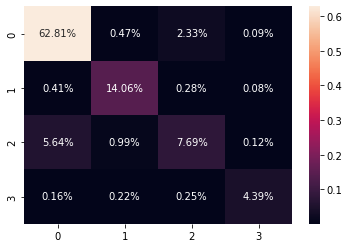

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  80.85%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     85565
           1       0.72      0.98      0.83     19319
           2       0.39      0.06      0.10     18805
           3       0.90      0.50      0.64      6550

    accuracy                           0.81    130239
   macro avg       0.71      0.62      0.62    130239
weighted avg       0.76      0.81      0.76    130239

             Confusion_matrix 


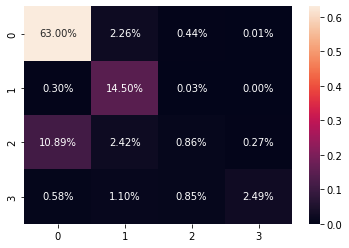

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  91.48%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.93      0.97      0.95     19319
           2       0.83      0.57      0.68     18805
           3       0.97      0.91      0.94      6550

    accuracy                           0.91    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.91      0.91    130239

             Confusion_matrix 


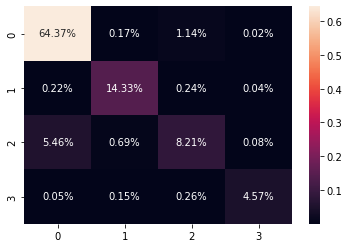

###################- End -###################
#############################################
######-Model => <class 'sklearn.naive_bayes.GaussianNB'> 
Test Accuracy :  78.95%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85565
           1       0.66      1.00      0.79     19319
           2       0.60      0.02      0.04     18805
           3       0.61      0.70      0.65      6550

    accuracy                           0.79    130239
   macro avg       0.68      0.66      0.59    130239
weighted avg       0.77      0.79      0.74    130239

             Confusion_matrix 


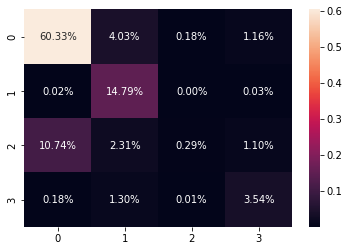

###################- End -###################


In [ ]:
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()  # Creamos una instancia del modelo () a partir de la clase.
    
    # Entrenamos el modelo con los datos
    # X_train: features (variables) de entrenamiento.
    # y_train: etiquetas (categorías: benign, phishing, malware, defacement).
    
    model_.fit(X_train, y_train) 

    # El modelo ya entrenado predice las etiquetas para los datos de prueba.
    # pred contendrá las clases predichas (0,1,2,3).
    
    pred = model_.predict(X_test)

    # Calculamos la accuracy (exactitud) comparando pred con las etiquetas reales (y_test).
    
    acc = accuracy_score(pred, y_test)

    # Se almacena el valor en la lista accuracy_test.
    
    accuracy_test.append(acc)

    # Imprime la exactitud del modelo en porcentaje 
    
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))

    #Muestra el informe de clasificación, que incluye:
        # precision (qué tan precisas son las predicciones por clase).
        # recall (qué porcentaje de elementos de una clase fueron correctamente identificados).
        # f1-score (media armónica de precision y recall).
        # support (cantidad de ejemplos de cada clase en el test set).
    
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))

    # Calcula la matriz de confusión, que muestra cómo se distribuyeron los aciertos y errores entre clases.
    
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)

    # Normaliza la matriz dividiendo por el total (np.sum(cf_matrix)), así los valores se ven en porcentaje.

        # Usa sns.heatmap para graficar la matriz de confusión.
        # annot=True pone los valores encima de cada celda.
        # fmt='0.2%' los muestra en formato de porcentaje con dos decimales.
        # plt.show() muestra el gráfico.
    
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()

    # Imprime un separador en color rojo para indicar que terminó la iteracción del modelo
    
    print('\033[31m###################- End -###################\033[0m')

         Modelo  Accuracy
0  DecisionTree  0.909274
1  RandomForest  0.915002
2      AdaBoost  0.820077
3           KNN  0.889618
4           SGD  0.808544
5    ExtraTrees  0.914787
6    GaussianNB  0.789548


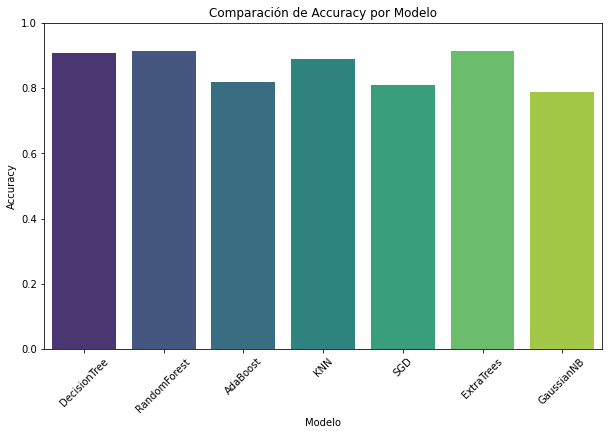

In [ ]:
# Lista de nombres de modelos (en el mismo orden que 'models')
model_names = [
    "DecisionTree", 
    "RandomForest", 
    "AdaBoost", 
    "KNN", 
    "SGD", 
    "ExtraTrees", 
    "GaussianNB"
]

# Crear un DataFrame con resultados
results = pd.DataFrame({
    "Modelo": model_names,
    "Accuracy": accuracy_test
})

# Mostrar tabla de resultados
print(results)

# Gráfico comparativo
plt.figure(figsize=(10,6))
sns.barplot(x="Modelo", y="Accuracy", data=results, palette="viridis")
plt.title("Comparación de Accuracy por Modelo")
plt.ylabel("Accuracy")
plt.ylim(0,1)   # escala de 0 a 100%
plt.xticks(rotation=45)
plt.show()


<a id="8"></a> <br>
# <img src="https://cdn-icons-png.flaticon.com/64/3094/3094836.png"/> Final Report

In [ ]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

In [ ]:
output

,Model,Accuracy
0,Decision Tree Classifier,0.909274
1,Random Forest Classifier,0.915002
2,AdaBoost Classifier,0.820077
3,KNeighbors Classifier,0.889618
4,SGD Classifier,0.808544
5,Extra Trees Classifier,0.914787
6,Gaussian NB,0.789548


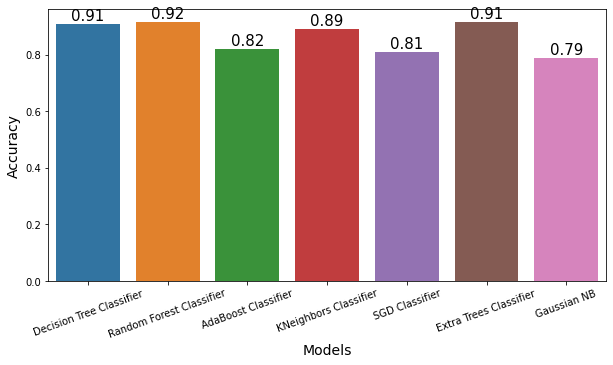

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

         Modelo  Accuracy  Train_Time  Predict_Time
0  DecisionTree  0.909443    2.922248      0.048012
1  RandomForest  0.914734   82.589403      4.538696
2      AdaBoost  0.820077   19.412343      1.089038
3           KNN  0.889618    4.921289     27.184806
4           SGD  0.818480   63.245043      0.014929
5    ExtraTrees  0.914718   67.639833      5.886628
6    GaussianNB  0.789548    0.217269      0.063333


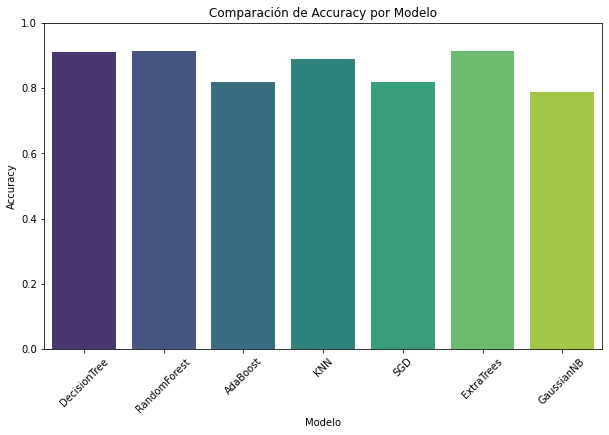

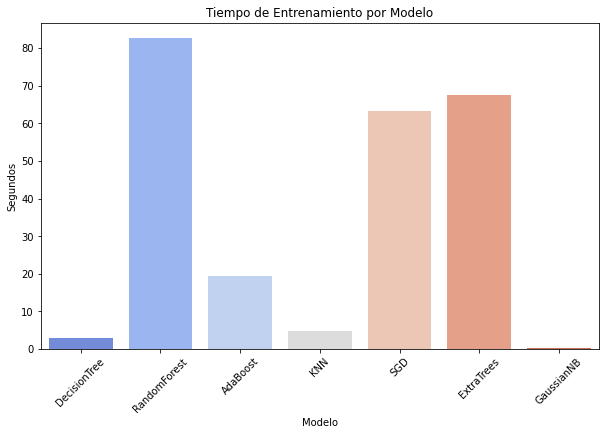

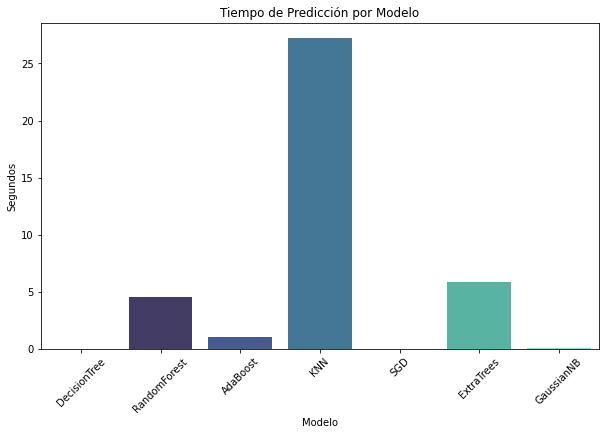

In [ ]:
import time

models = [
    DecisionTreeClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    KNeighborsClassifier,
    SGDClassifier,
    ExtraTreesClassifier,
    GaussianNB
]

model_names = [
    "DecisionTree", 
    "RandomForest", 
    "AdaBoost", 
    "KNN", 
    "SGD", 
    "ExtraTrees", 
    "GaussianNB"
]

accuracy_test = []
train_times = []
predict_times = []

for m, name in zip(models, model_names):
    
    model_ = m()
    
    # Medir tiempo de entrenamiento
    start_train = time.time()
    model_.fit(X_train, y_train)
    end_train = time.time()
    train_time = end_train - start_train
    
    # Medir tiempo de predicción
    start_pred = time.time()
    pred = model_.predict(X_test)
    end_pred = time.time()
    pred_time = end_pred - start_pred
    
    # Guardar métricas
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    train_times.append(train_time)
    predict_times.append(pred_time)

# Crear DataFrame de resultados
results = pd.DataFrame({
    "Modelo": model_names,
    "Accuracy": accuracy_test,
    "Train_Time": train_times,
    "Predict_Time": predict_times
})

print(results)

# Gráfico comparativo de accuracy
plt.figure(figsize=(10,6))
sns.barplot(x="Modelo", y="Accuracy", data=results, palette="viridis")
plt.title("Comparación de Accuracy por Modelo")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.show()

# Gráfico comparativo de tiempos de entrenamiento
plt.figure(figsize=(10,6))
sns.barplot(x="Modelo", y="Train_Time", data=results, palette="coolwarm")
plt.title("Tiempo de Entrenamiento por Modelo")
plt.ylabel("Segundos")
plt.xticks(rotation=45)
plt.show()

# Gráfico comparativo de tiempos de predicción
plt.figure(figsize=(10,6))
sns.barplot(x="Modelo", y="Predict_Time", data=results, palette="mako")
plt.title("Tiempo de Predicción por Modelo")
plt.ylabel("Segundos")
plt.xticks(rotation=45)
plt.show()


<a id="9"></a> <br>
# ✨ Conclusiones

### 1. Precisión de los modelos:

- RandomForest y ExtraTrees logran la mayor precisión (~ 91,5%), seguidos de DecisionTree (~ 90,9%).
- Modelos simples como GaussianNB y SGD presentan menor precisión (~ 78–81%).

### 2. Tiempo de entrenamiento y predicción:

- DecisionTree y GaussianNB son rápidos en entrenamiento y predicción.
- RandomForest y ExtraTrees requieren mayor tiempo de entrenamiento y predicción.
- KNN tiene predicción muy lenta, poco práctico para tiempo real.

### 3. Balance precisión-tiempo:

- DecisionTree ofrece el mejor equilibrio entre precisión y eficiencia.
- RandomForest y ExtraTrees recomendables si se prioriza la máxima precisión y el tiempo no es crítico.

### 4. Recomendaciones de uso:

- Producción en tiempo real: DecisionTree o GaussianNB.
- Máxima precisión sin límite de tiempo: RandomForest o ExtraTrees.
- Evitar en producción: KNN y modelos de baja precisión como SGD/AdaBoost.Aqui las conclusiones